# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       #transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# MPS?
mps = torch.backends.mps.is_available()
print("MPS Available?", mps)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
elif mps:
    torch.mps.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda or mps else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False
MPS Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


/Users/qureshsu/.local/share/virtualenvs/S6-JNyiktla/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([128, 1, 28, 28])
torch.Size([128])


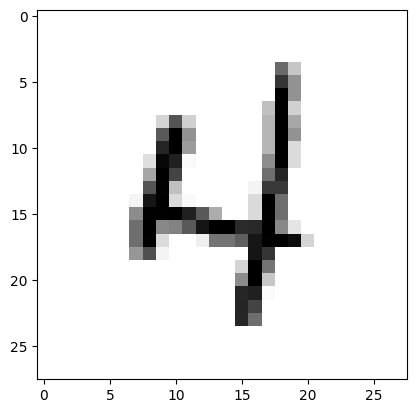

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

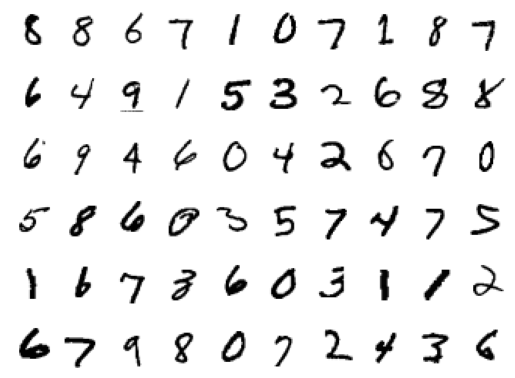

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [9]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device = torch.device("cuda" if use_cuda else "mps" if use_mps else "cpu")
device

device(type='mps')

In [10]:
from model import Model_1_2

model = Model_1_2(device).to(device)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
from model import model_summary
model_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,640
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          18,496
              ReLU-6           [-1, 64, 22, 22]               0
         MaxPool2d-7           [-1, 64, 11, 11]               0
            Conv2d-8           [-1, 16, 11, 11]           1,040
            Conv2d-9             [-1, 32, 9, 9]           4,640
             ReLU-10             [-1, 32, 9, 9]               0
           Conv2d-11             [-1, 64, 7, 7]          18,496
             ReLU-12             [-1, 64, 7, 7]               0
           Conv2d-13            [-1, 128, 5, 5]          73,856
             ReLU-14            [-1, 12

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [12]:
from model import model_train, model_test

# Let's Train and test our model

### Block 1 : Model_1_2
Target:

1- Designed the Model architecture to hit the RF to atleast cover the content of the image

3- Yet no trandformation applied


Results:
1- Parameters: 270k

2- Best Training Accuracy: 99.44

3- Best Test Accuracy: 99.04

Analysis:

1- Still Heavy Model for small problem

2- Model started to overfit in later epochs

In [14]:
model = Model_1_2(device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, verbose=True)

criterion = F.nll_loss

for epoch in range(1, 16):
    print("Epoch ", epoch)
    model_train(model, device, train_loader, optimizer, criterion)
    model_test(model, device, test_loader, criterion)
    #scheduler.step()

Epoch  1


Train: Loss=2.3081 Batch_id=468 Accuracy=11.16: 100%|██████████| 469/469 [00:10<00:00, 45.82it/s]



Test set: Average loss: 2.3008, Accuracy: 1135/10000 (11.35%)

Epoch  2


Train: Loss=0.5567 Batch_id=468 Accuracy=24.50: 100%|██████████| 469/469 [00:07<00:00, 58.89it/s]



Test set: Average loss: 0.4201, Accuracy: 8677/10000 (86.77%)

Epoch  3


Train: Loss=0.0467 Batch_id=468 Accuracy=94.53: 100%|██████████| 469/469 [00:08<00:00, 58.54it/s]



Test set: Average loss: 0.0836, Accuracy: 9741/10000 (97.41%)

Epoch  4


Train: Loss=0.0545 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:08<00:00, 57.94it/s]



Test set: Average loss: 0.0657, Accuracy: 9790/10000 (97.90%)

Epoch  5


Train: Loss=0.0212 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:08<00:00, 57.57it/s]



Test set: Average loss: 0.0500, Accuracy: 9844/10000 (98.44%)

Epoch  6


Train: Loss=0.0466 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:08<00:00, 57.25it/s]



Test set: Average loss: 0.0460, Accuracy: 9850/10000 (98.50%)

Epoch  7


Train: Loss=0.0251 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:08<00:00, 57.21it/s]



Test set: Average loss: 0.0385, Accuracy: 9882/10000 (98.82%)

Epoch  8


Train: Loss=0.0358 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:08<00:00, 57.85it/s]



Test set: Average loss: 0.0419, Accuracy: 9864/10000 (98.64%)

Epoch  9


Train: Loss=0.0098 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:08<00:00, 57.46it/s]



Test set: Average loss: 0.0402, Accuracy: 9867/10000 (98.67%)

Epoch  10


Train: Loss=0.0084 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:08<00:00, 57.20it/s]



Test set: Average loss: 0.0295, Accuracy: 9901/10000 (99.01%)

Epoch  11


Train: Loss=0.0461 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:08<00:00, 57.23it/s]



Test set: Average loss: 0.0312, Accuracy: 9904/10000 (99.04%)

Epoch  12


Train: Loss=0.0022 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:08<00:00, 57.05it/s]



Test set: Average loss: 0.0338, Accuracy: 9906/10000 (99.06%)

Epoch  13


Train: Loss=0.0038 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:08<00:00, 57.60it/s]



Test set: Average loss: 0.0327, Accuracy: 9889/10000 (98.89%)

Epoch  14


Train: Loss=0.0143 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:08<00:00, 56.94it/s]



Test set: Average loss: 0.0369, Accuracy: 9888/10000 (98.88%)

Epoch  15


Train: Loss=0.0137 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:08<00:00, 57.91it/s]



Test set: Average loss: 0.0331, Accuracy: 9896/10000 (98.96%)



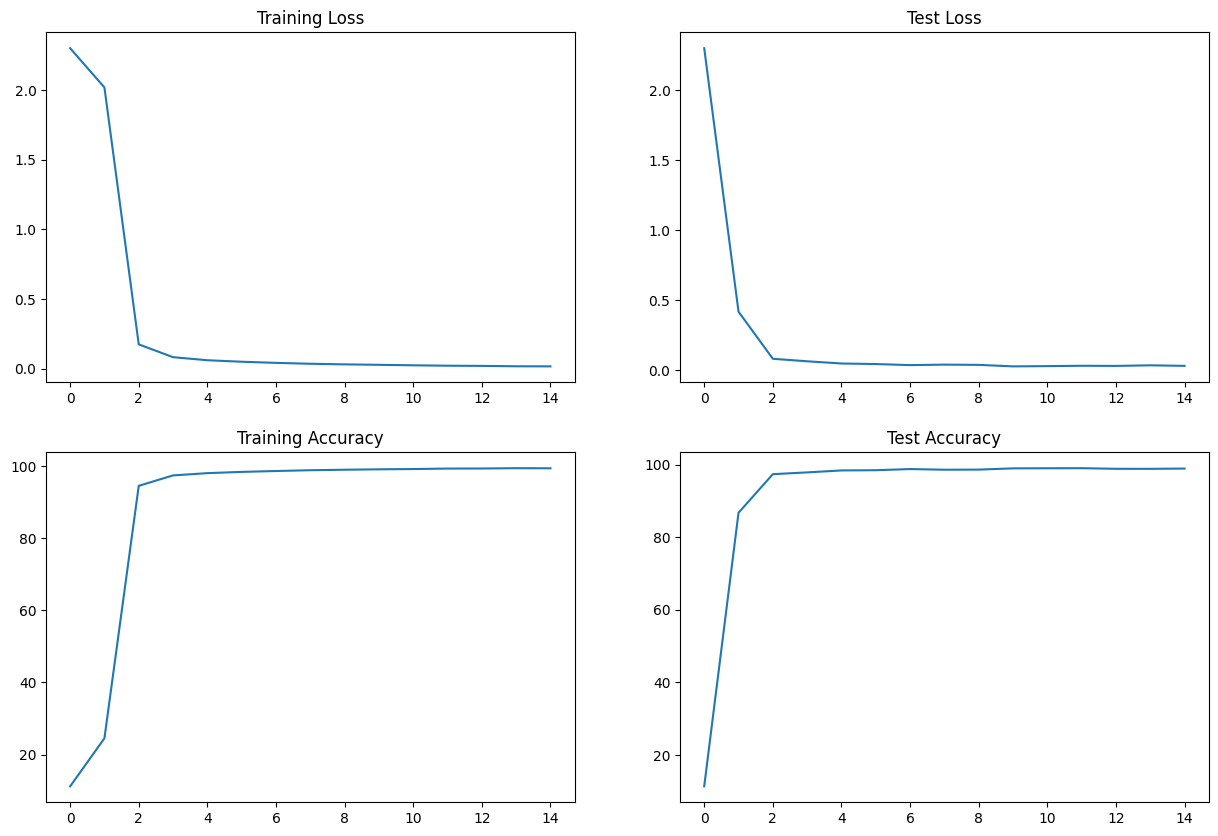

In [15]:
from model import draw_graphs

draw_graphs()